In [1]:
# toc
import os

import matplotlib.pyplot as plt
import certifi
import numpy as np
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score

# keras/tensorflow
from keras.api.datasets import cifar10
from keras.api.models import Sequential, load_model
from keras.api.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from keras.api.callbacks import ModelCheckpoint
import tensorflow as tf

# If you have a raw python installation, you have to set the SSL_CERT_FILE environment variable
os.environ['SSL_CERT_FILE'] = certifi.where()

tf.config.set_visible_devices([], 'GPU')
plt.style.use('../maroon_ipynb.mplstyle')

# Problem 1

Keras includes the CIFAR-10 dataset, a collection of 60,000 32x32 color images. Each contains 1 of 10 different objects, and the dataset is often used as a benchmark for classification schemes. The 10 different classes are: airplane, car, bird, cat, deer, dog, frog, horse, ship, and truck. In this assignment you will build a CNN to attempt to correctly classify these images.

Check the labels on the data to see how many of each class are present in the training and test datasets. Do you foresee any issues with this data balance? Plot a few of the images as well to get a sense for what the images look like to the human eye.

## Solution

In [2]:
# load the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# normalize the data
x_train = x_train/255
x_test = x_test/255

Upon inspection of the data, we see that `x_train` is a 50,000x32x32x3 array meaning we have 50,000 images of size 32x32 with 3 color channels. `y_train` is a 50,000x1 array of labels. `x_test` is a 10,000x32x32x3 array and `y_test` is a 10,000x1 array of labels. The target values are represented with integers from 0 to 9, corresponding to the class names below as the `class_names` list.

Let's show the first of each class that we see in the training data.

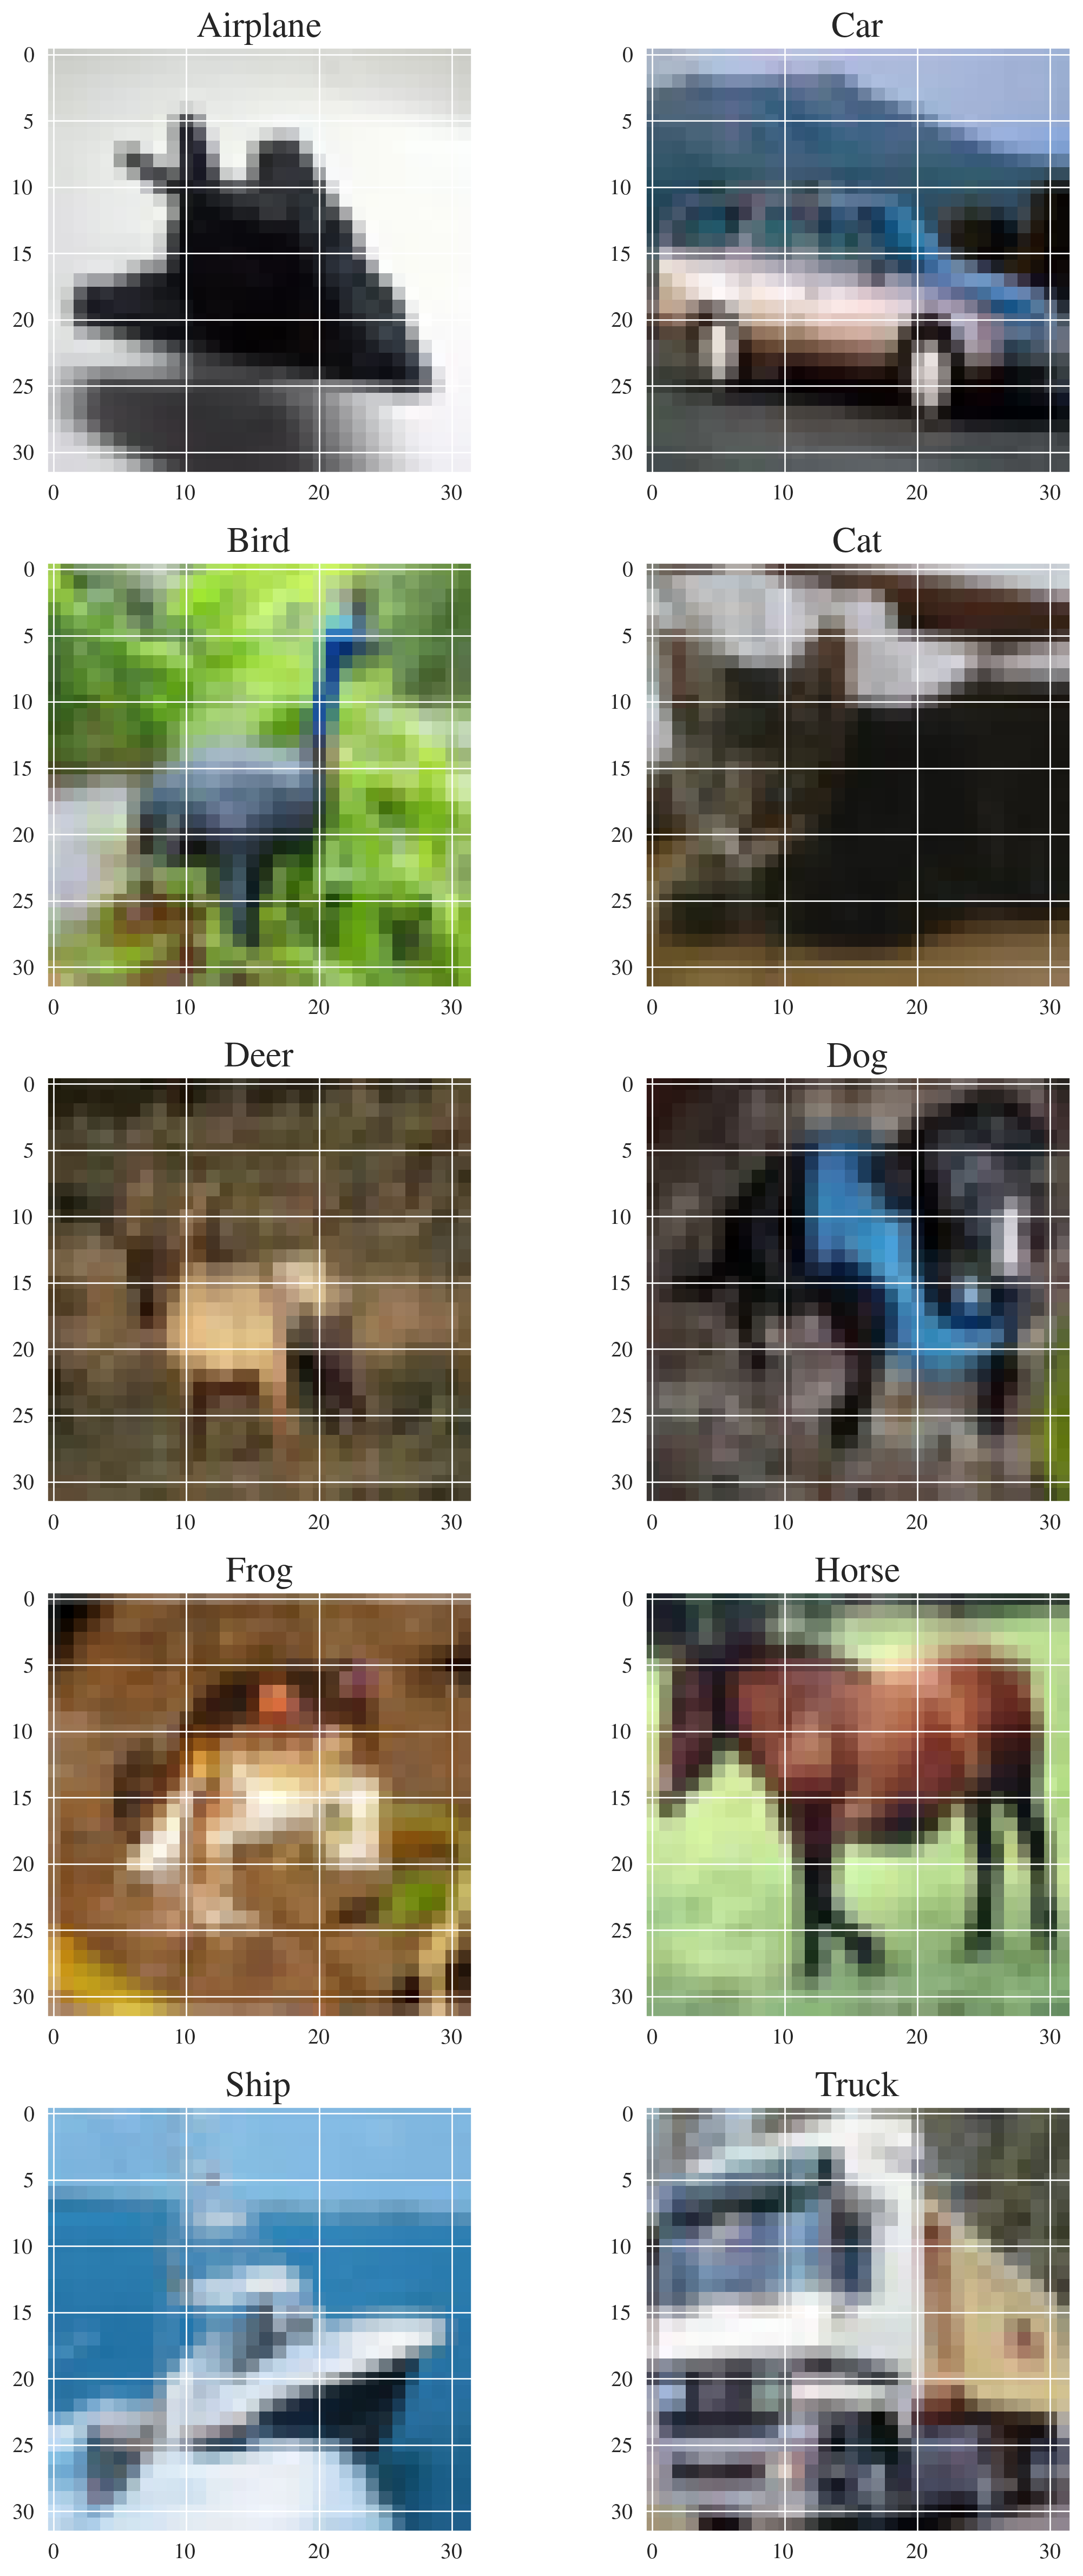

In [3]:
# Plotting the images
# class names order is seen in the doc strings of cifar10
class_names = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
classes_seen = set()

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
axes = ax.flatten()

i = 0
while len(classes_seen) < len(class_names):
    label = y_train[i][0]
    if label not in classes_seen:
        classes_seen.add(label)
        axes[label].imshow(x_train[i])
        axes[label].set_title(class_names[label])
    i += 1
plt.show()

In [4]:
# Finding the number of each class in the training and test data
train_counts = np.bincount(y_train.flatten())
test_counts = np.bincount(y_test.flatten())

# print the counts
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {train_counts[i]} training images, {test_counts[i]} test images')

Airplane: 5000 training images, 1000 test images
Car: 5000 training images, 1000 test images
Bird: 5000 training images, 1000 test images
Cat: 5000 training images, 1000 test images
Deer: 5000 training images, 1000 test images
Dog: 5000 training images, 1000 test images
Frog: 5000 training images, 1000 test images
Horse: 5000 training images, 1000 test images
Ship: 5000 training images, 1000 test images
Truck: 5000 training images, 1000 test images


The CIFAR-10 dataset is designed so that each of the 10 classes has the same number of images—specifically, 5000 training images and 1000 test images per class. This balance ensures that models trained on the dataset don’t become biased towards any one class and helps provide a fair evaluation during testing. So no, I don't foresee any issues with this data balance.

# Problem 2
Build a simple CNN with a single convolution layer and a single dense hidden layer and train it over the data. Plot the evolution of the accuracy and the loss as a function of epoch. Show a confusion matrix for the best result from the training.

## Solution

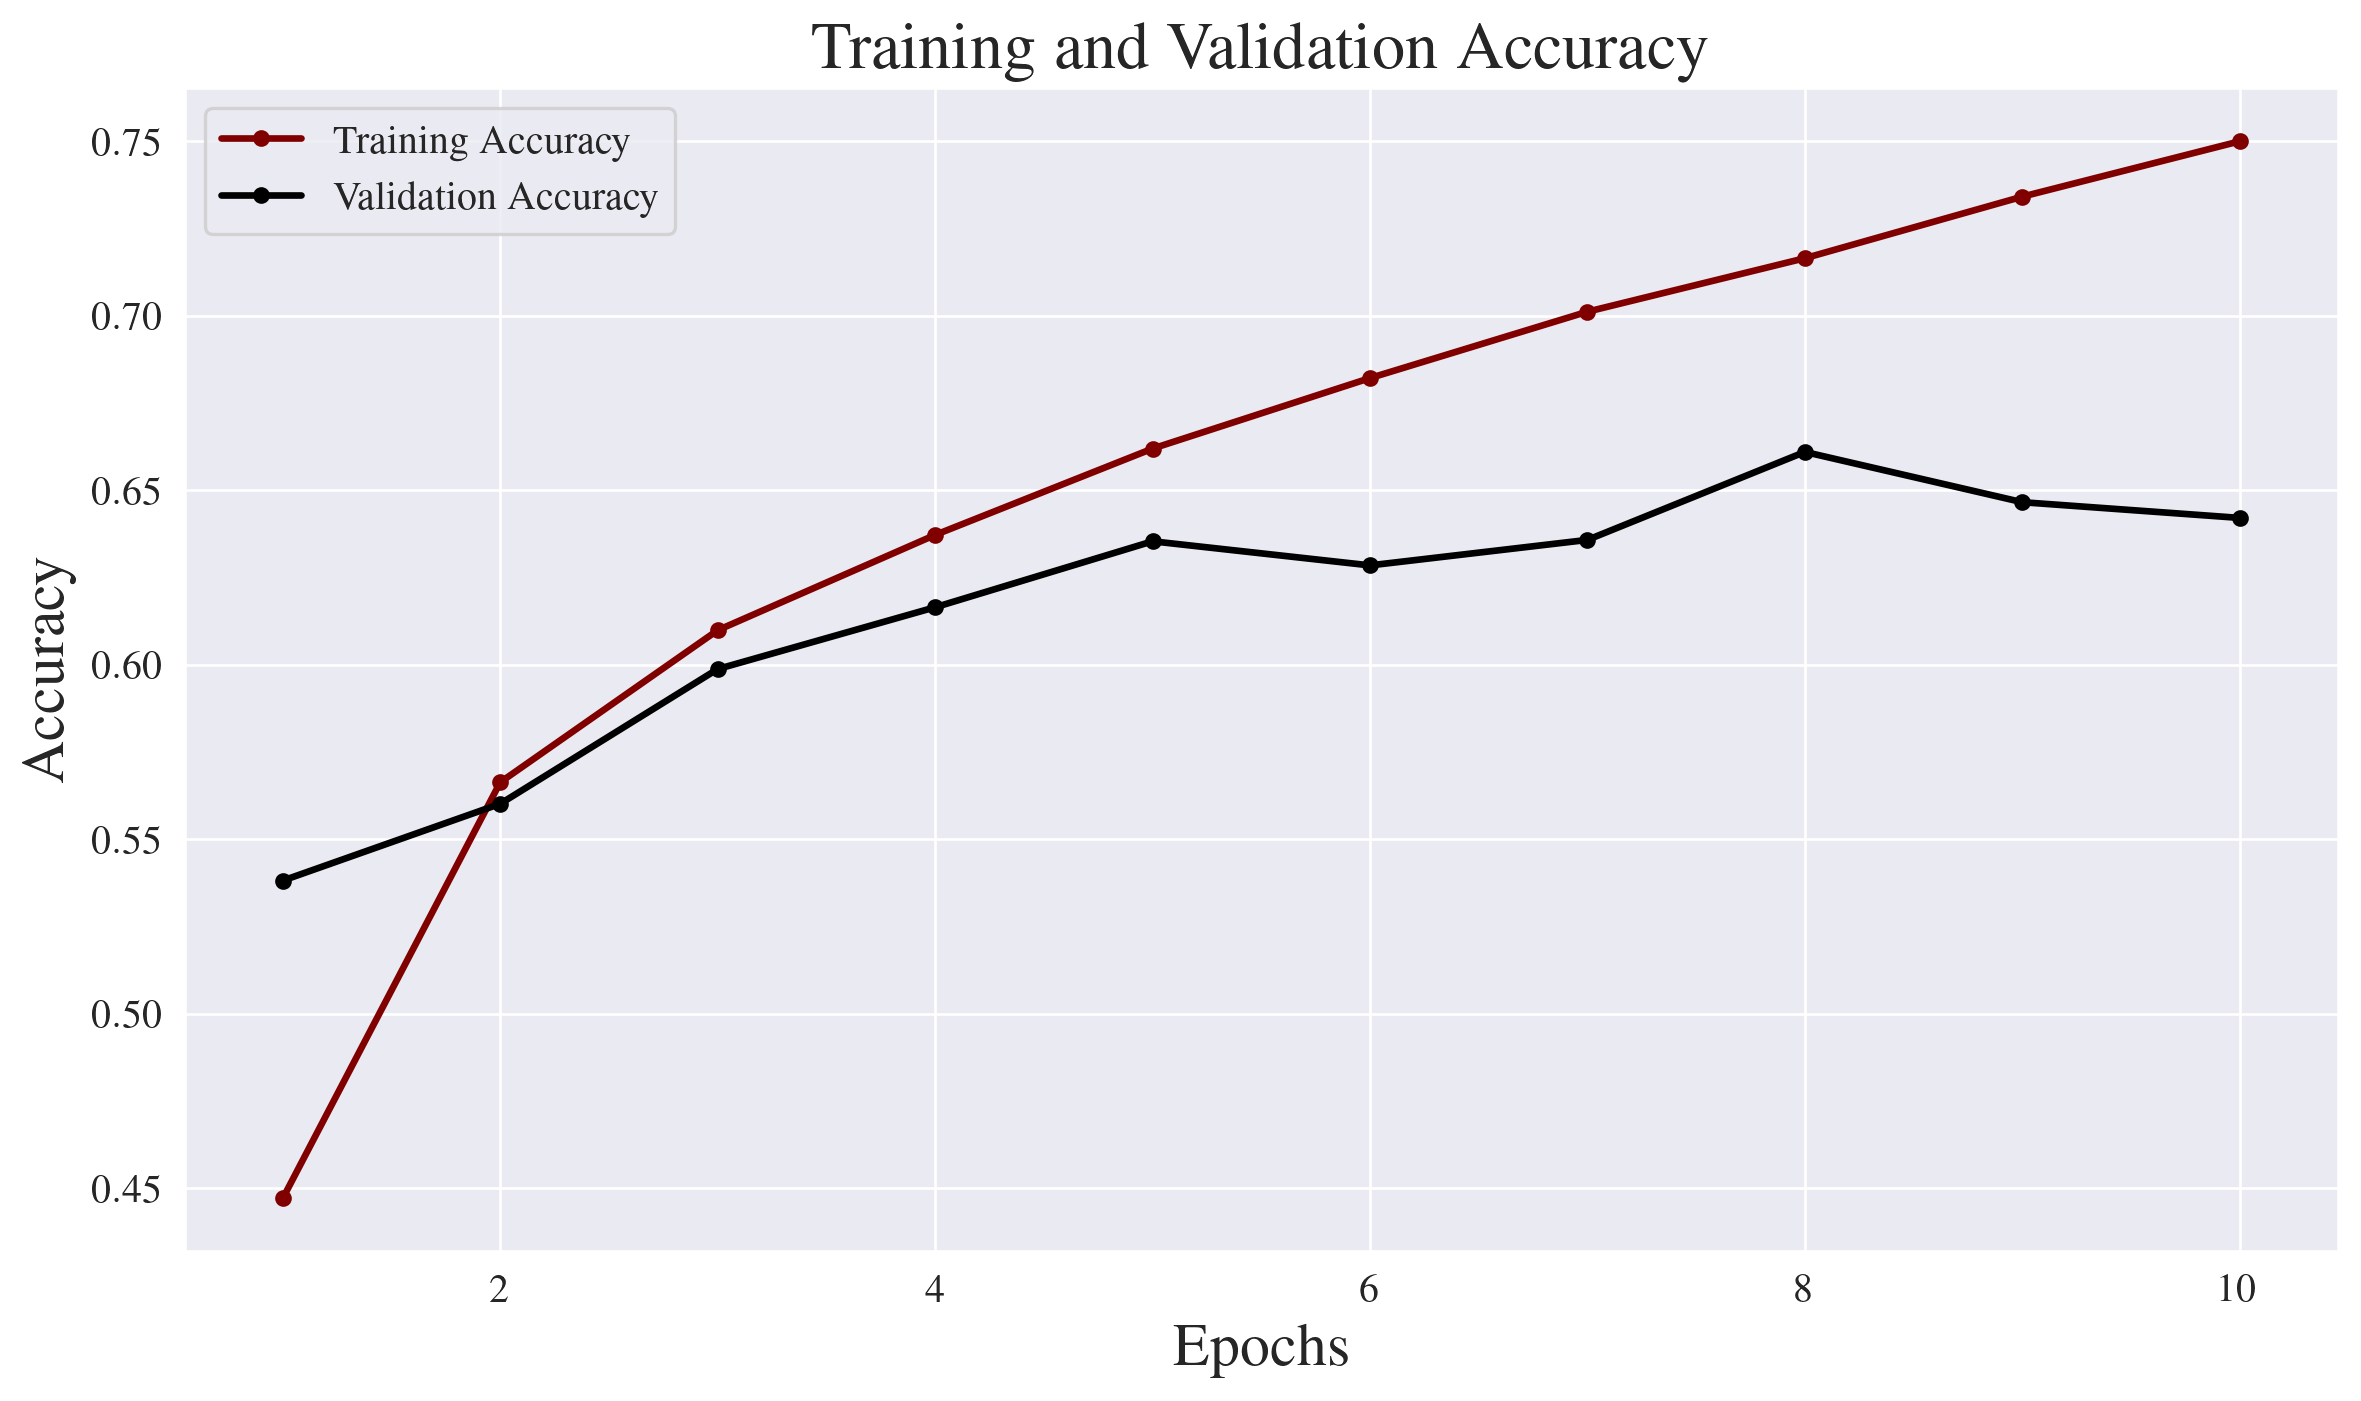

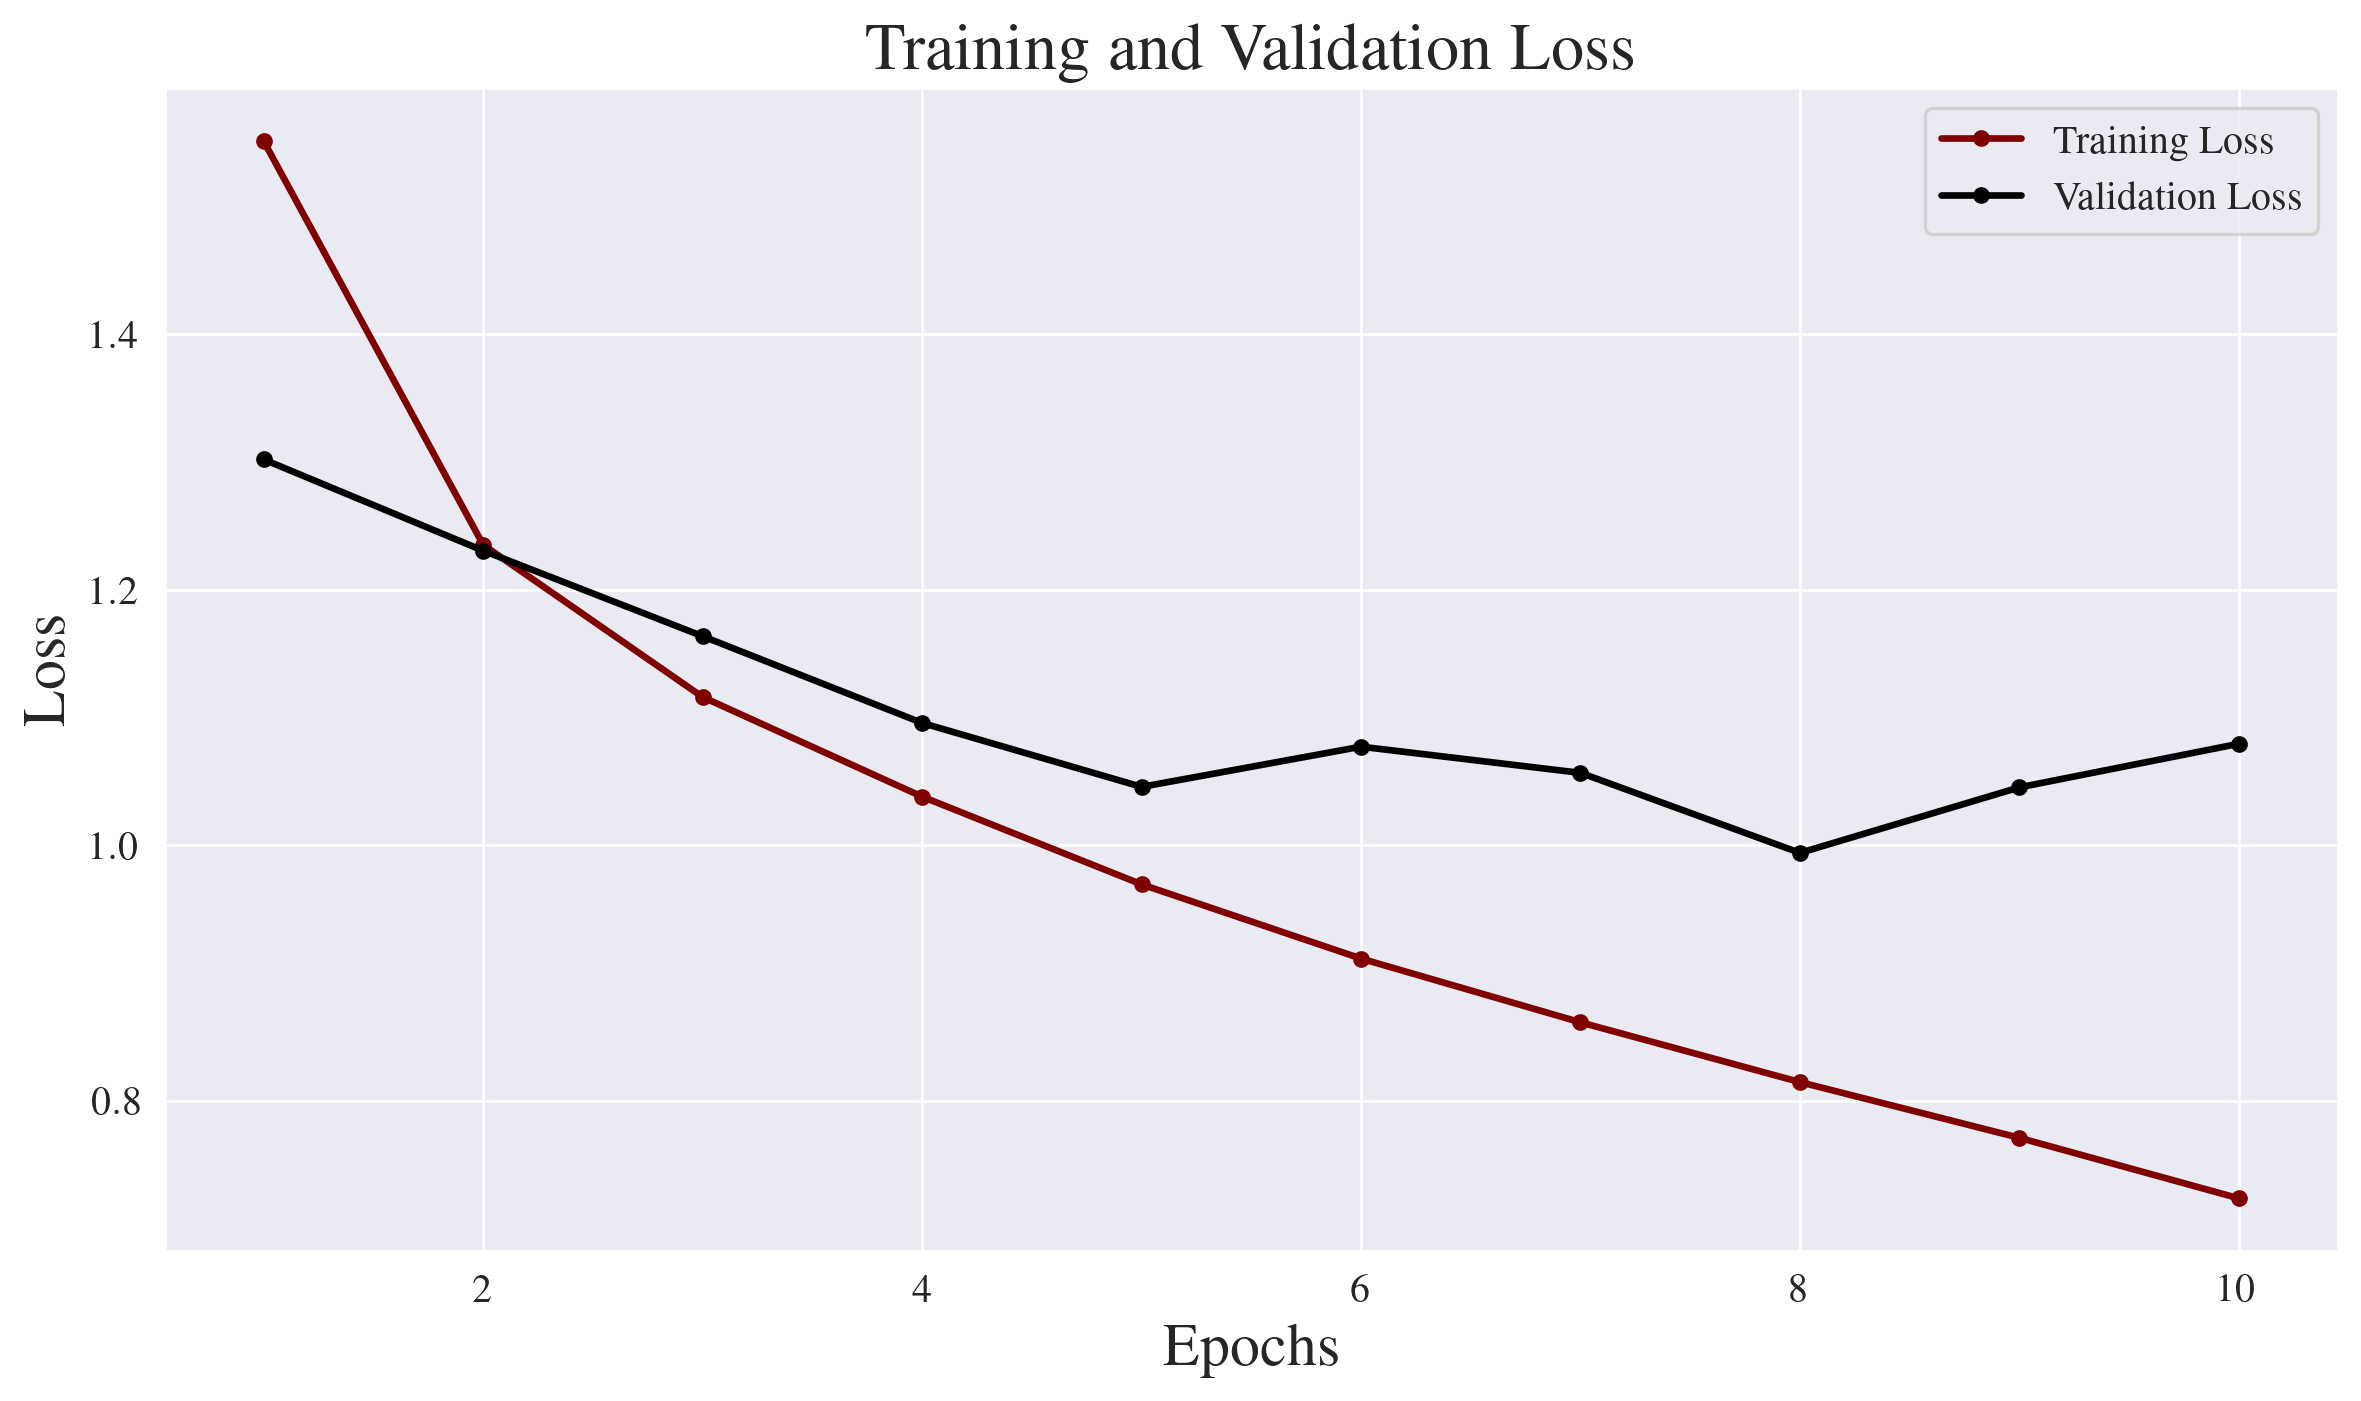

In [5]:
# Create model
p2_model = Sequential([
    Input(shape=(32, 32, 3)),  # input shape
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),  # convolution layer
    MaxPooling2D(pool_size=(2, 2)),  # max pooling layer
    Flatten(),  # flatten the output
    Dense(128, activation='relu'),  # dense hidden layer
    Dense(10, activation='softmax')  # output layer with softmax activation
])

# Compile model
p2_model.compile(
    optimizer='adam',  # optimizer
    loss='sparse_categorical_crossentropy',  # loss function for multi-class classification
    metrics=['accuracy']  # metric to track
)

# Define callback to save the best model based on validation accuracy
checkpoint_callback = ModelCheckpoint(
    'best_model_p2.keras',  # file to save the model
    monitor='val_accuracy',  # monitor validation accuracy
    save_best_only=True,  # save only the best model
    mode='max',  # maximize the monitored metric
    verbose=False  # suppress output
)

# Train the model
history = p2_model.fit(
    x_train, y_train,  # training data
    epochs=10,  # number of epochs
    batch_size=64,  # batch size
    validation_data=(x_test, y_test),  # validation data
    callbacks=[checkpoint_callback],  # callback to save the best model
    verbose=False  # suppress output during training
)
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.array(history.epoch) + 1

# Plot the training and validation accuracy
fig, ax = plt.subplots()
ax.plot(epochs, train_accuracy, label='Training Accuracy', marker='.')
ax.plot(epochs, val_accuracy, label='Validation Accuracy', marker='.')
ax.set_title('Training and Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

# Plot the training and validation loss
fig, ax = plt.subplots()
ax.plot(epochs, train_loss, label='Training Loss', marker='.')
ax.plot(epochs, val_loss, label='Validation Loss', marker='.')
ax.set_title('Training and Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

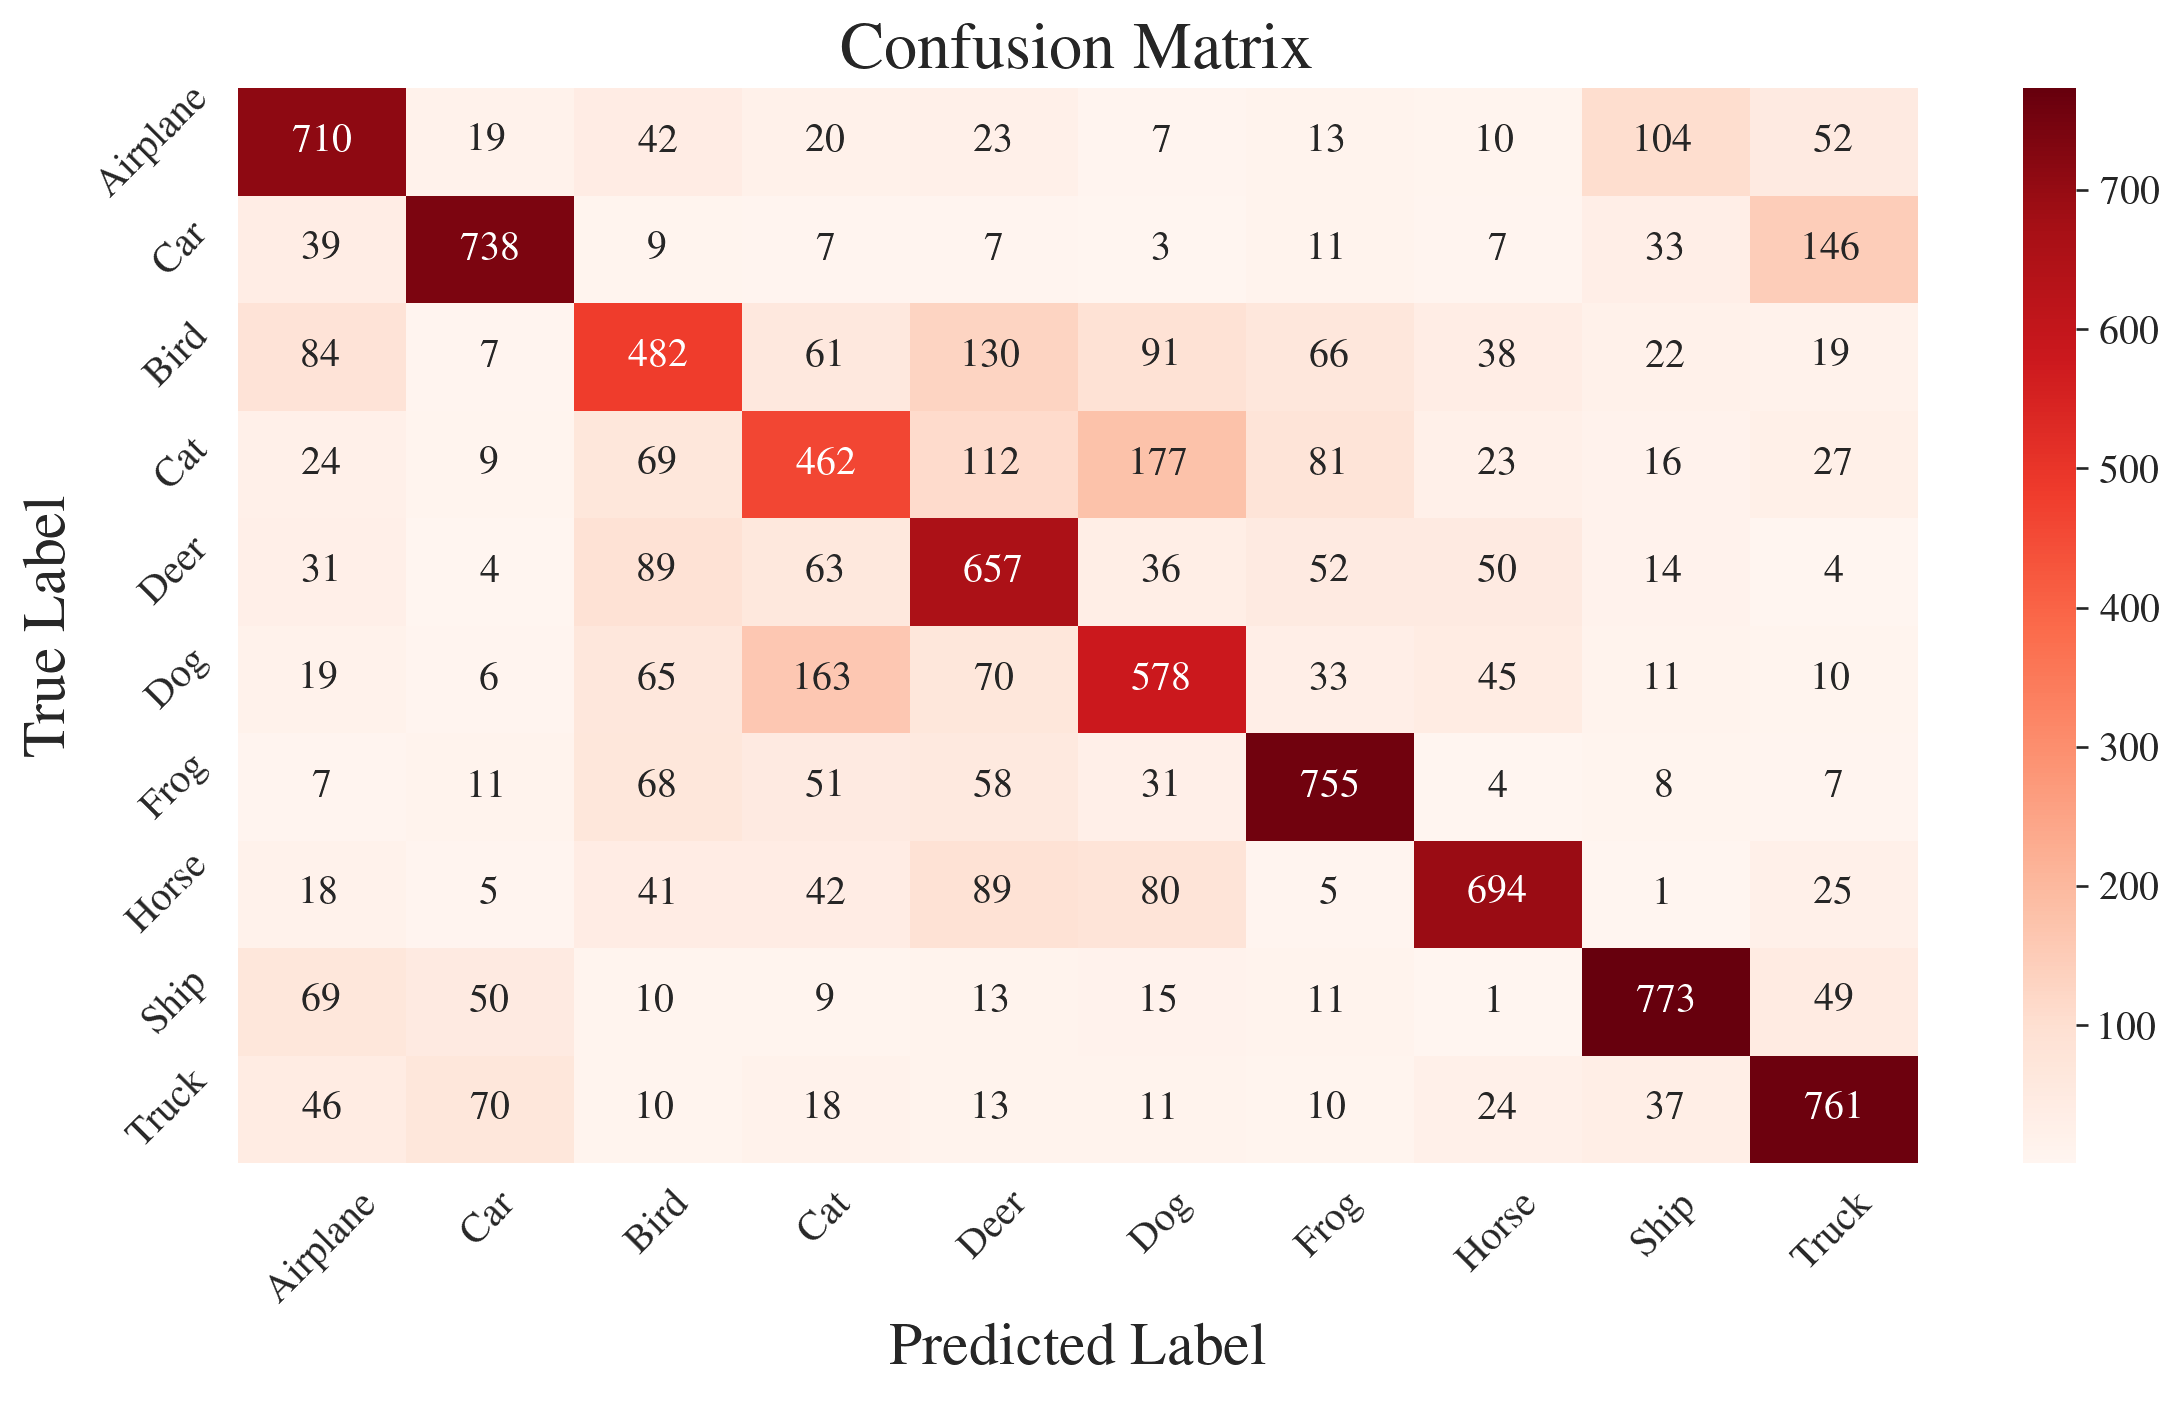

In [6]:
# Making the confusion matrix
p2_best_model = load_model('best_model_p2.keras')  # Load the best model
y_pred = p2_best_model.predict(x_test, verbose=False)  # Get predictions on the test set

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)  # finding the highest probability
cm = confusion_matrix(y_test.flatten(), y_pred_labels)

# Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=45)
plt.show()

In [7]:
# Accuracy score
accuracy = accuracy_score(y_test.flatten(), y_pred_labels)
print(f'Accuracy of the best model on the test set: {accuracy:.3%}')

Accuracy of the best model on the test set: 66.100%
